# `alternate_rates`

Sometimes papers provide new measurements of rates that may be better than the current ReacLib library.  An example of this is the 
[DeBoer et al. 2012](https://ui.adsabs.harvard.edu/abs/2017RvMP...89c5007D/abstract) ${}^{12}\mathrm{C}(\alpha, \gamma){}^{16}\mathrm{O}$ rate.

These rates can be added individually to the `alternate_rates` module.

In [1]:
import pynucastro as pyna

## Comparison of ${}^{12}\mathrm{C}(\alpha, \gamma){}^{16}\mathrm{O}$

Here we compare the ReacLib and deBoer versions of ${}^{12}\mathrm{C}(\alpha, \gamma){}^{16}\mathrm{O}$.

First get the ReacLib version

In [2]:
rl = pyna.ReacLibLibrary()
c12_rl = rl.get_rate_by_name("c12(a,g)o16")

Now the DeBoer version:

In [3]:
from pynucastro.rates.alternate_rates import DeBoerC12agO16
c12_deboer = DeBoerC12agO16()

Note that since DeBoer et al. 2012 give the new rate as a parameterization in the ReacLib form, this new rate just subclasses
`ReacLibRate`

In [4]:
DeBoerC12agO16.__base__

pynucastro.rates.rate.ReacLibRate

Let's plot a comparison of the rates

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
Ts = np.logspace(7.5, 9.5, 100)

r_rl = np.array([c12_rl.eval(T) for T in Ts])
r_deboer = np.array([c12_deboer.eval(T) for T in Ts])

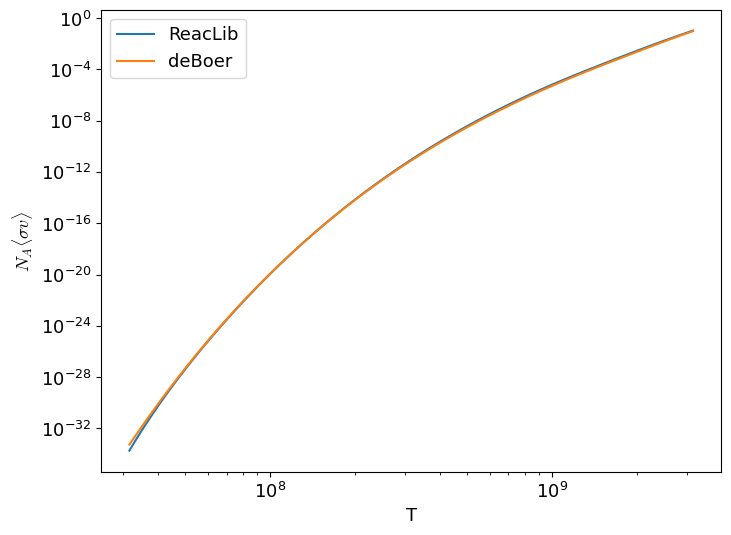

In [7]:
fig, ax = plt.subplots()
ax.loglog(Ts, r_rl, label="ReacLib")
ax.loglog(Ts, r_deboer, label="deBoer")
ax.set_xlabel("T")
ax.set_ylabel(r"$N_A\langle \sigma v\rangle$")
ax.legend()

Here's the relative difference

Text(0, 0.5, 'relative difference')

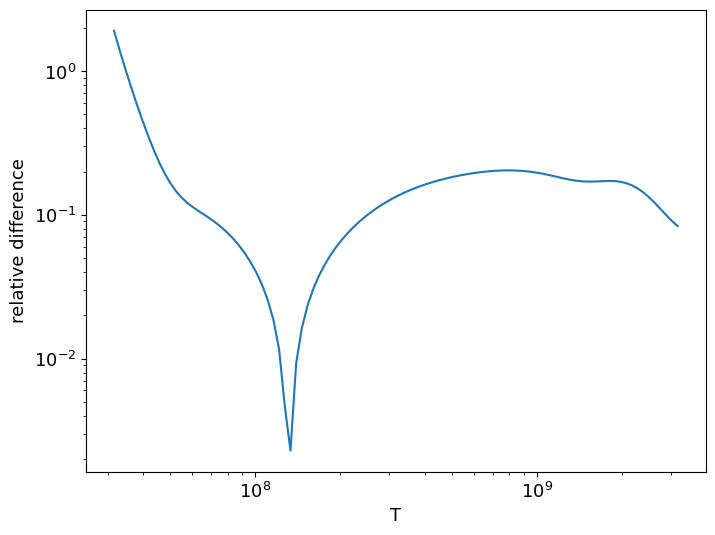

In [8]:
fig, ax = plt.subplots()
ax.loglog(Ts, np.abs((r_rl - r_deboer) / r_rl))
ax.set_xlabel("T")
ax.set_ylabel(r"relative difference")

## Using alternate rates in a network

To create a network with this rate, we can swap it in for the ReacLib version when we create a library.
Here's a simple He-burning network.

In [9]:
nuclei = ["p", "he4", "c12", "o16", "ne20", "na23", "mg24"]

comp = pyna.Composition(nuclei)
comp.set_equal()

In [10]:
rho = 1.e6
T = 1.e9

### Pure ReacLib

First we'll create a `RateCollection` with just the ReacLib rates

In [11]:
lib = rl.linking_nuclei(nuclei, with_reverse=False)
rc = pyna.RateCollection(libraries=[lib])
rates = rc.evaluate_rates(rho, T, comp)
for rr, val in rates.items():
    print(f"{str(rr):25} : {val:12.7e}")

C12 + He4 ⟶ O16 + 𝛾       : 2.7441793e-03
O16 + He4 ⟶ Ne20 + 𝛾      : 1.1385847e+00
Ne20 + He4 ⟶ Mg24 + 𝛾     : 4.1265513e-01
Na23 + p ⟶ Mg24 + 𝛾       : 6.9202360e+05
C12 + C12 ⟶ p + Na23      : 1.1970613e-09
C12 + C12 ⟶ He4 + Ne20    : 1.4808559e-09
O16 + C12 ⟶ He4 + Mg24    : 5.5470507e-15
Na23 + p ⟶ He4 + Ne20     : 8.9374939e+06
He4 + He4 + He4 ⟶ C12 + 𝛾 : 2.5845076e-03


### Swapping in DeBoer rate

Now we'll swap in the deBoer rate.

In [12]:
lib.remove_rate(c12_rl)
lib.add_rate(c12_deboer)

and recreate the new `RateCollection`

In [13]:
rc2 = pyna.RateCollection(libraries=[lib])
rates = rc2.evaluate_rates(rho, T, comp)
for rr, val in rates.items():
    print(f"{str(rr):25} : {val:12.7e}")

O16 + He4 ⟶ Ne20 + 𝛾      : 1.1385847e+00
Ne20 + He4 ⟶ Mg24 + 𝛾     : 4.1265513e-01
Na23 + p ⟶ Mg24 + 𝛾       : 6.9202360e+05
C12 + C12 ⟶ p + Na23      : 1.1970613e-09
C12 + C12 ⟶ He4 + Ne20    : 1.4808559e-09
O16 + C12 ⟶ He4 + Mg24    : 5.5470507e-15
Na23 + p ⟶ He4 + Ne20     : 8.9374939e+06
He4 + He4 + He4 ⟶ C12 + 𝛾 : 2.5845076e-03
C12 + He4 ⟶ O16 + 𝛾       : 2.2040004e-03


Comparing to the pure ReacLib version, we see the only difference in the evaluation
of the rates is in ${}^{12}\mathrm{C}(\alpha, \gamma){}^{16}\mathrm{O}$